# Visualisation notebook: U.S. Presidential Election 2016

This notebook contains summary statistics and results for our analysis of defamation in the 2016 U.S. Presidential Election Project

Including:

- hashtags
- term frequency
- topic visualisation
- unique accounts, tweet counts, avg num tweets per user
- incoporate topic over time
- tweets over time (based on topic label, count how many that date)

# Load packages

In [11]:
import pickle
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import colour
from colour import Color
import collections
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load data

In [2]:
# load all data
clean_tweets = pickle.load(open('clean_tweets', 'rb'))

original_df_en = pd.read_csv('en_tweets.csv')
original_df_en = original_df_en.drop(['Unnamed: 0'], axis=1)

clean_df = pd.read_csv('clean_df.csv', low_memory=False)
clean_df = clean_df.drop(['Unnamed: 0'], axis=1)

topics_df = pd.read_csv('mallet17_topics_by_tweet.csv')

In [3]:
original_df_en.columns, clean_df.columns

(Index(['tweetid', 'userid', 'user_screen_name', 'user_reported_location',
        'user_profile_description', 'tweet_text', 'hashtags', 'tweet_language',
        'tweet_time', 'follower_count', 'following_count'],
       dtype='object'),
 Index(['clean_tweet', 'hashtags', 'mentions', 'emojis'], dtype='object'))

# Visuals

### hashtags

In [5]:
hashtags = [x for x in clean_df['hashtags'] if str(x) != 'nan']

In [6]:
# put hashtags in dictionary to see most frequent ones
hashtag_counter = collections.Counter(hashtags)

# sort by frequency
hashtag_counter = {k: v for k, v in sorted(hashtag_counter.items(), key=lambda item: item[1])}

# remove all keys with values < than 450 to get top 20 hashtags
hashtag_counter = {k:v for k,v in hashtag_counter.items() if v >= 450}

# drop tweets with no hashtags
hashtag_counter = {k:v for k,v in hashtag_counter.items() if k != ''}

# get top 20 hashtags
# hashtag_counter = [hashtag_counter[k] for k in sorted(hashtag_counter.keys())[:20]]

In [7]:
len(hashtag_counter)

20

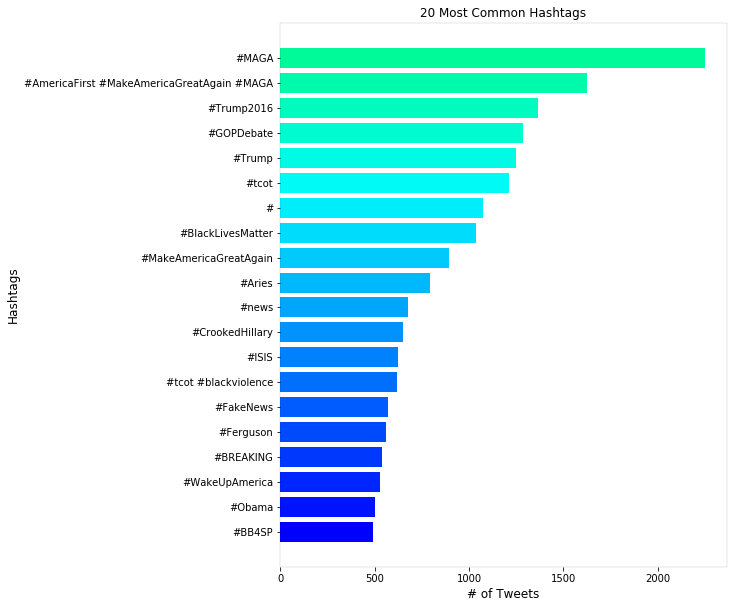

In [12]:
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)

fig, ax = plt.subplots(figsize=(8,10))

blue = Color('blue')
colors = list(blue.range_to(Color('mediumspringgreen'),len(hashtag_counter)))
colors = [color.rgb for color in colors]

ax.barh(range(len(hashtag_counter)), hashtag_counter.values(), align='center', color=colors)
ax.set_yticks(range(len(hashtag_counter)))
ax.set_yticklabels(list(hashtag_counter.keys()))
ax.set_title('20 Most Common Hashtags')
ax.set_ylabel('Hashtags')
ax.set_xlabel('# of Tweets')
plt.show()

### removing rare words

In [13]:
# join all tweets together so it's a long list of words
all_words = [word for sent in clean_tweets for word in sent]

# calculate the frequency of each of the words
freq_dist = nltk.FreqDist(all_words)

# create list of words that appear <= 3 times in the whole corpus
rare_words = {k:v for k,v in freq_dist.items() if v <= 15}

# append other words to rare_words that we think should be removed
words_to_add = {'rt': 1, 
                'http': 1, 
                'https': 1}

rare_words.update(words_to_add)

clean_tweets_final = [[word for word in sent if word not in rare_words.keys()] for sent in clean_tweets]

In [14]:
# difference in length before after removing rare words
len(freq_dist), len(rare_words)

(129066, 115277)

In [15]:
i = np.random.randint(low=0, high=len(clean_tweets))
print('***tweet before removing rare words***')
print(clean_tweets[i])
print('===========================================')
print('***tweet after removing rare words***')
print(clean_tweets_final[i])

***tweet before removing rare words***
['rt', 'costa', 'mesa', 'trump', 'honoring', 'family', 'ppl', 'killed', 'illegal', 'alien', 'http']
***tweet after removing rare words***
['costa', 'mesa', 'trump', 'honoring', 'family', 'ppl', 'killed', 'illegal', 'alien']


In [98]:
# # Pick new clean_tweets
# import pickle
# # Pickle results
# with open('clean_tweets_final', 'wb') as results:
#     pickle.dump((clean_tweets_final), results)

### vectorizer

In [16]:
# # join tweet words to input into the vectorizer
clean_tweets_joint = [' '.join(words) for words in clean_tweets_final]

In [17]:
# load the vec model
vectorizer = TfidfVectorizer(stop_words='english',
                             use_idf=False)

v = vectorizer.fit_transform(clean_tweets_joint)
v = np.asarray(v.todense())

In [18]:
# get the labels (vocabulary), sorted by index
labels, _ = zip(*sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1]))

In [19]:
len(labels)

12829

In [20]:
# put the labels and average frequency into a dataframe 
# so it'as easier to work with
labels_df = pd.DataFrame({'label': list(labels), 'mean': np.mean(v,axis=0)})

labels_df = labels_df.sort_values(by=('mean'), ascending=False)

In [21]:
# select only top 20 words with highest frequency (otherwise it's a 
# list of 12000 words)
labels_to_plot = labels_df.iloc[0:20,:]
labels_to_plot = labels_to_plot.sort_values(by=('mean'))
len(labels_to_plot)

20

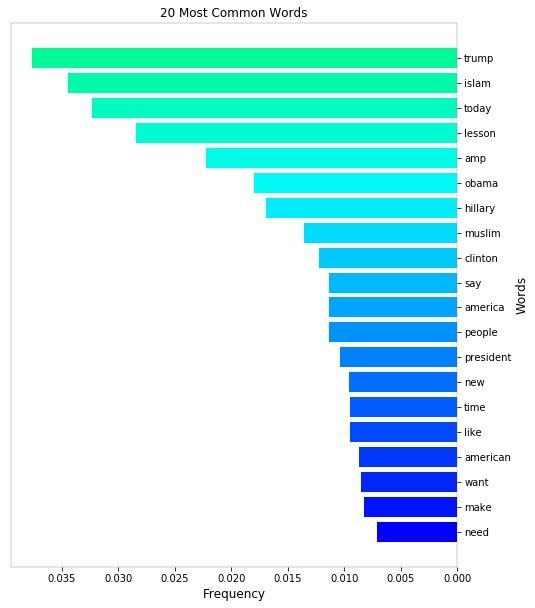

In [142]:
# plot the results 

plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)

fig, ax = plt.subplots(figsize=(8,10))

blue = Color('blue')
colors = list(blue.range_to(Color('mediumspringgreen'),len(labels_to_plot['label'])))
colors = [color.rgb for color in colors]

ax.set_yticklabels([]) # Hide the left y-axis tick-labels
ax.set_yticks([]) # Hide the left y-axis ticks
ax.set_xlabel('Frequency')
ax1 = ax.twinx() # Create a twin x-axis
ax1.barh(labels_to_plot['label'], 
         labels_to_plot['mean'], 
         align='center', color=colors) # Plot using `ax1` instead of `ax`
ax1.set_yticks(range(len(labels_to_plot['label'])))
ax1.set_yticklabels(labels_to_plot['label'])
ax1.set_ylabel('Words')
ax1.set_xlabel('Frequency')

ax.invert_yaxis()  # labels read top-to-bottom
ax.invert_xaxis()  # labels read top-to-bottom

ax.set_title('20 Most Common Words')
# ax.set_ylabel('Words')

plt.show()

### other visuals

In [23]:
# unique accounts, tweet counts, avg num tweets per user

In [24]:
# concat all into a new dataframe
full_df = pd.concat([clean_df, 
                     original_df_en,
                     topics_df[['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']]],
                     axis=1)

In [25]:
full_df.columns

Index(['clean_tweet', 'hashtags', 'mentions', 'emojis', 'tweetid', 'userid',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'tweet_text', 'hashtags', 'tweet_language',
       'tweet_time', 'follower_count', 'following_count', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords'],
      dtype='object')

In [26]:
# unique accounts
# full_df[['userid']].groupby(['col1']).agg(['mean', 'count'])
unique_accounts = np.arange(0, int(full_df[['userid']].nunique().values))
num_tweets_account = full_df.groupby(['userid']).size().values

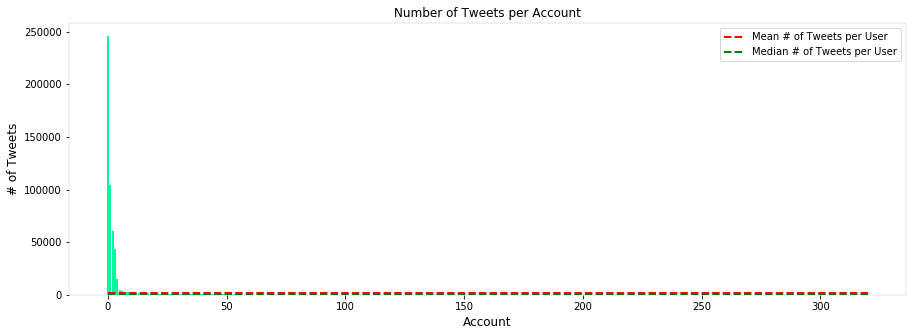

In [27]:
plt.figure(figsize=(15,5))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)
plt.style.use('seaborn-bright')

blue = Color('mediumspringgreen')
colors = list(blue.range_to(Color('blue'),len(unique_accounts)))
colors = [color.rgb for color in colors]

plt.bar(unique_accounts, -np.sort(-num_tweets_account), align='center', color=colors)
plt.hlines(np.mean(num_tweets_account), 0, 320, color='red', linewidths=2,
           linestyles='dashed', label='Mean # of Tweets per User')
plt.hlines(np.median(num_tweets_account), 0, 320, color='green', linewidths=2,
           linestyles='dashed', label='Median # of Tweets per User')
plt.title('Number of Tweets per Account')
plt.ylabel('# of Tweets')
plt.xlabel('Account')
plt.legend()
plt.show()

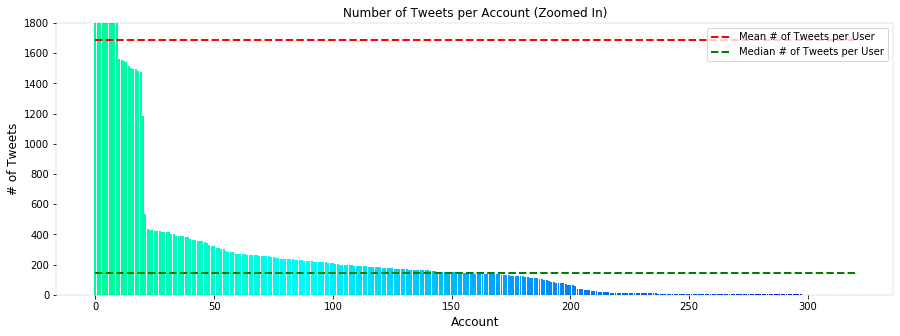

In [31]:
plt.figure(figsize=(15,5))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)
plt.style.use('seaborn-bright')

blue = Color('mediumspringgreen')
colors = list(blue.range_to(Color('blue'),len(unique_accounts)))
colors = [color.rgb for color in colors]

plt.bar(unique_accounts, -np.sort(-num_tweets_account), align='center', color=colors)
plt.hlines(np.mean(num_tweets_account), 0, 320, color='red', linewidths=2,
           linestyles='dashed', label='Mean # of Tweets per User')
plt.hlines(np.median(num_tweets_account), 0, 320, color='green', linewidths=2,
           linestyles='dashed', label='Median # of Tweets per User')
plt.title('Number of Tweets per Account (Zoomed In)')
plt.ylabel('# of Tweets')
plt.xlabel('Account')
plt.legend()
plt.ylim(0,1800)
plt.show()

In [33]:
# incoporate topic over time
# tweets over time (based on topic label, count how many that date)

In [34]:
# put the relevant info in a dataframe and sort by num of tweets
tweets_topic = pd.DataFrame({'topic': full_df['Keywords'].unique(),
                             'num_tweets': full_df.groupby(['Keywords'], sort=False).size().values})
tweets_topic = tweets_topic.sort_values(by=['num_tweets'])

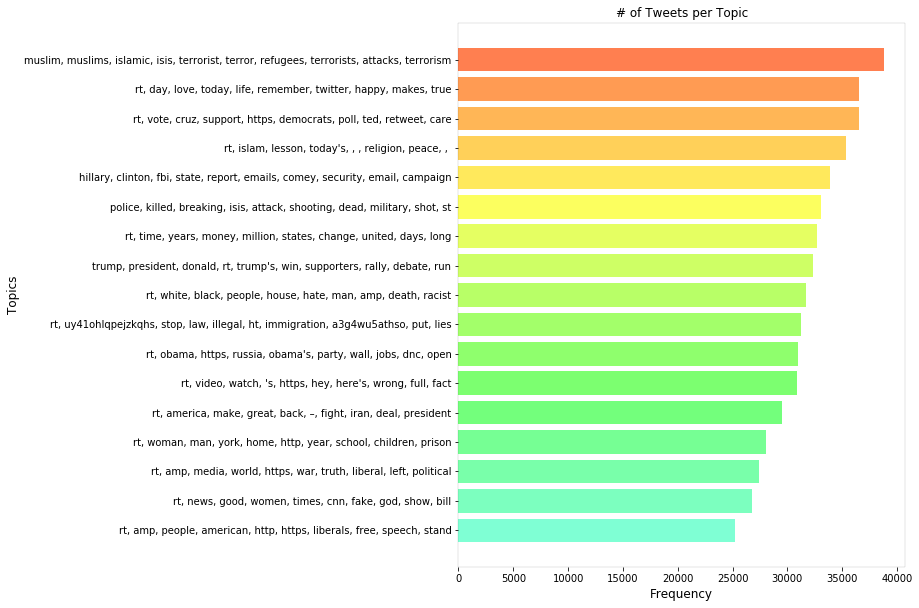

In [35]:
from colour import Color

blue = Color('aquamarine')
colors = list(blue.range_to(Color('coral'),len(tweets_topic['topic'])))
colors = [color.rgb for color in colors]

plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)

fig, ax = plt.subplots(figsize=(8,10))

ax.barh(tweets_topic['topic'],
         tweets_topic['num_tweets'],
         align='center',
         color=colors)
ax.set_title('# of Tweets per Topic')
ax.set_ylabel('Topics')
ax.set_xlabel('Frequency')
plt.show()

In [36]:
# get the top tweeters (those who have more than 1000 tweets)

twitter_accounts = full_df['userid'].unique()
tweets_per_account = full_df.groupby(['userid'], sort=False).size()

top_tweeters_df = pd.DataFrame({'account': twitter_accounts,
                                'num_tweets': tweets_per_account})
top_tweeters_df = top_tweeters_df[top_tweeters_df.num_tweets > 1000]
top_tweeters_df = top_tweeters_df.sort_values(by=['num_tweets'], ascending=False)
# top_tweeters_df = top_tweeters_df.reset_index(drop=True)

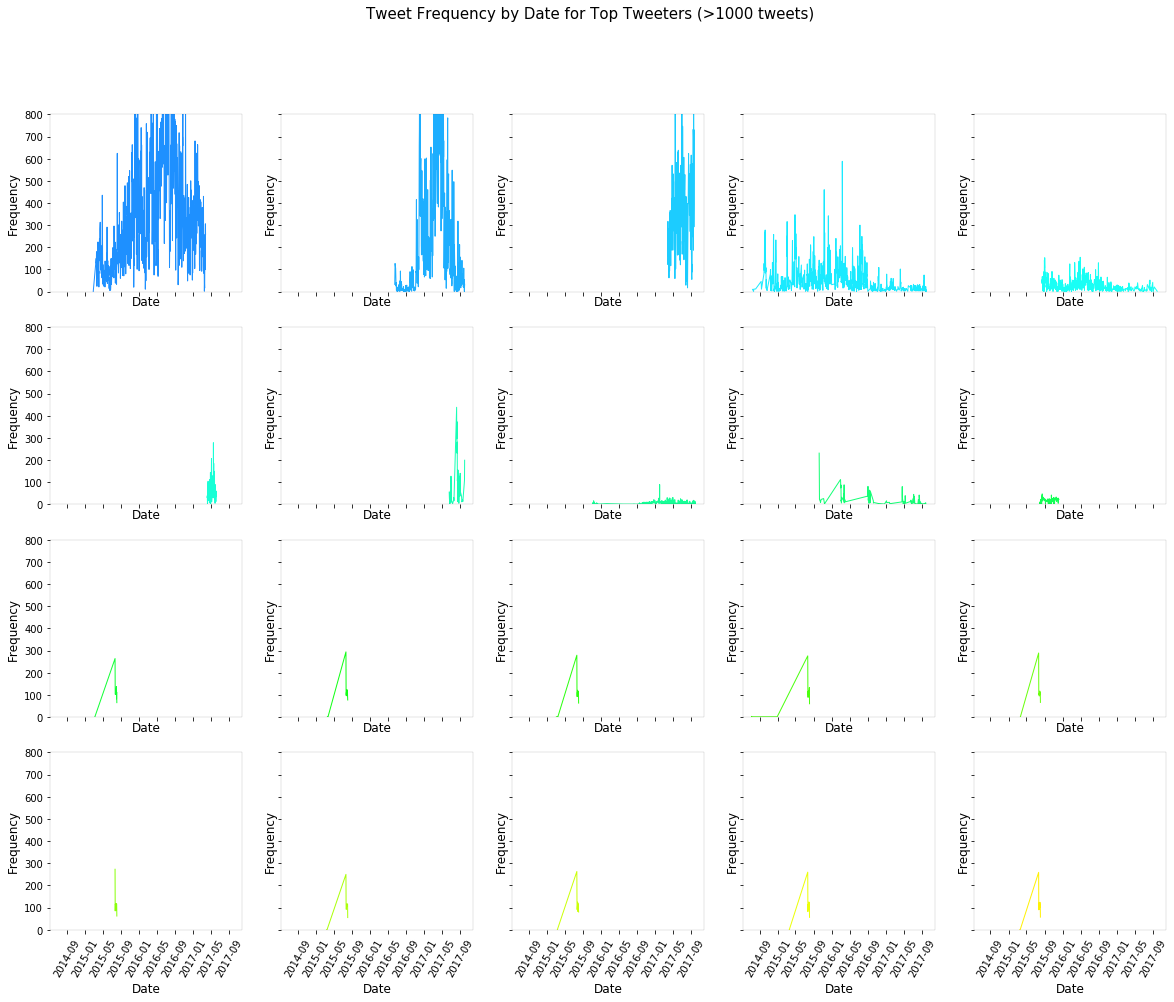

In [38]:
# plotting frequency of top tweeters over time
fig, axes = plt.subplots(4,5, sharex=True, sharey=True, figsize=(20,15))
fig.suptitle('Tweet Frequency by Date for Top Tweeters (>1000 tweets)', size=15)
top_accounts = list(top_tweeters_df['account'])
top_accounts.append(' '), top_accounts.append(' '), top_accounts.append(' '), top_accounts.append(' ')

blue = Color('dodgerblue')
colors = list(blue.range_to(Color('orangered'),len(top_accounts)))
colors = [color.rgb for color in colors]

for i, ax in enumerate(axes.flatten()):  
    top_df = full_df.copy()
    top_df['tweet_time'] = pd.to_datetime(top_df['tweet_time']).dt.date
    top_df = top_df[top_df['userid'] == top_accounts[i]]
    top_df = top_df[['tweet_time', 'tweet_text']]
    top_df = top_df.groupby(['tweet_time']).agg(['count'])
    ax.plot(top_df, linewidth=1, color=colors[i])
    ax.tick_params('x', labelrotation=60)
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')

# plt.tight_layout(pad=3)
plt.ylim(0,800)
plt.show()

In [39]:
# put the relevant topics info in a dataframe and sort by num of tweets
tweets_topic = pd.DataFrame({'topic': full_df['Keywords'].unique(),
                             'num_tweets': full_df.groupby(['Keywords'], sort=False).size().values})
tweets_topic = tweets_topic.sort_values(by=['num_tweets'])
tweets_topic = tweets_topic.reset_index(drop=True)

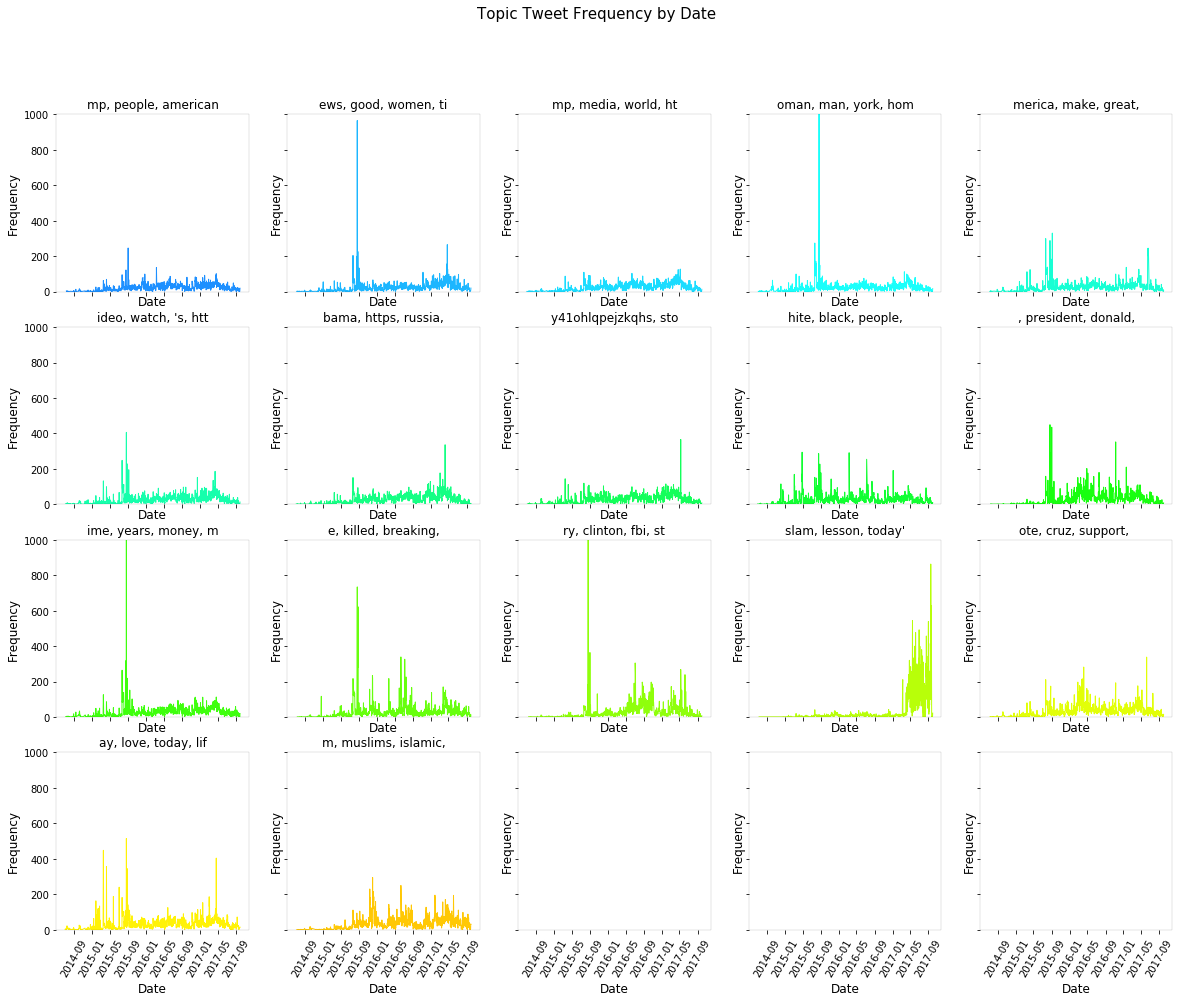

In [40]:
# plotting frequency of topics over time
fig, axes = plt.subplots(4,5, sharex=True, sharey=True, figsize=(20,15))
fig.suptitle('Topic Tweet Frequency by Date', size=15)
topic_list = list(tweets_topic['topic'])
topic_list.append(' '), topic_list.append(' '), topic_list.append(' ')
# fig.delaxes(axes[2,5])

blue = Color('dodgerblue')
colors = list(blue.range_to(Color('orangered'),len(topic_list)))
colors = [color.rgb for color in colors]

for i, ax in enumerate(axes.flatten()):  
    top_df = full_df.copy()
    top_df['tweet_time'] = pd.to_datetime(top_df['tweet_time']).dt.date
    top_df = top_df[top_df['Keywords'] == topic_list[i]]
    top_df = top_df[['tweet_time', 'tweet_text']]
    top_df = top_df.groupby(['tweet_time']).agg(['count'])
    ax.plot(top_df, linewidth=1, color=colors[i])
    ax.tick_params('x', labelrotation=60)
    ax.set_title(str(topic_list[i][5:25]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')

# plt.tight_layout(pad=3)
plt.ylim(0,1000)
plt.show()

In [41]:
# time of tweet

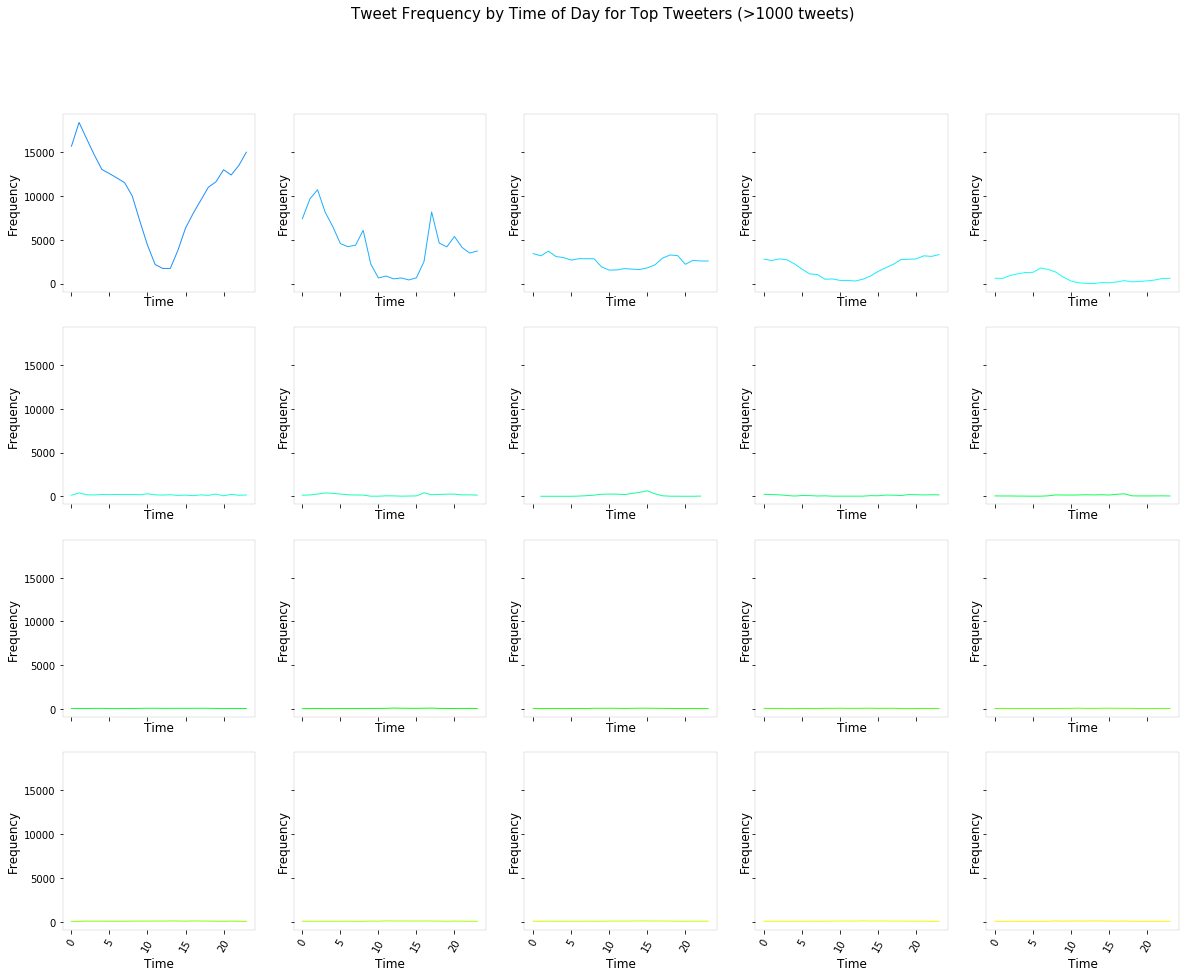

In [50]:
# plotting frequency of top tweeters by time of day
fig, axes = plt.subplots(4,5, sharex=True, sharey=True, figsize=(20,15))
fig.suptitle('Tweet Frequency by Time of Day for Top Tweeters (>1000 tweets)', size=15)
top_accounts = list(top_tweeters_df['account'])
top_accounts.append(' '), top_accounts.append(' '), top_accounts.append(' '), top_accounts.append(' ')

blue = Color('dodgerblue')
colors = list(blue.range_to(Color('orangered'),len(top_accounts)))
colors = [color.rgb for color in colors]

for i, ax in enumerate(axes.flatten()):  
    top_df = full_df.copy()
    top_df['tweet_time'] = pd.to_datetime(top_df['tweet_time']).dt.hour
    top_df = top_df[top_df['userid'] == top_accounts[i]]
    top_df = top_df[['tweet_time', 'tweet_text']]
    top_df = top_df.groupby(['tweet_time']).agg(['count'])
    ax.plot(top_df, linewidth=1, color=colors[i])
    ax.tick_params('x', labelrotation=60)
    ax.set_xlabel('Time') 
    ax.set_ylabel('Frequency')

# plt.tight_layout(pad=3)
# plt.ylim(0,1000)
plt.show()

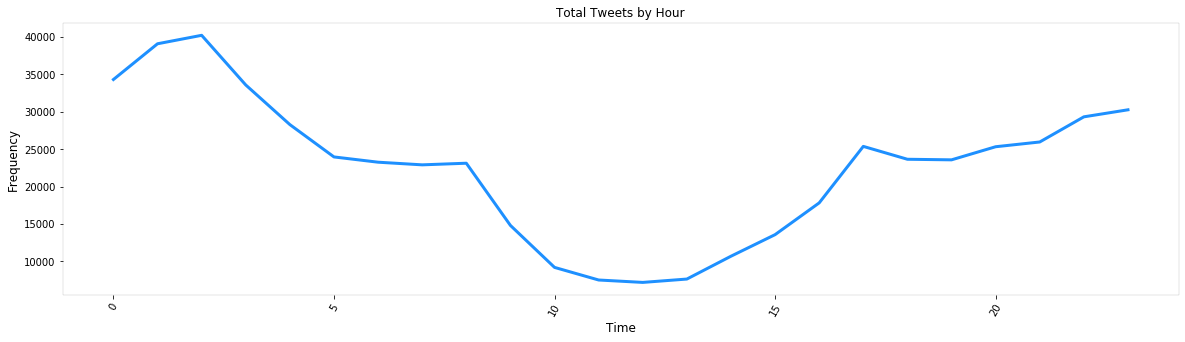

In [54]:
fig, ax = plt.subplots(figsize=(20,5))
top_df = full_df.copy()
top_df['tweet_time'] = pd.to_datetime(top_df['tweet_time']).dt.hour
top_df = top_df[['tweet_time', 'tweet_text']]
top_df = top_df.groupby(['tweet_time']).agg(['count'])
ax.plot(top_df, linewidth=3, color='dodgerblue')
ax.tick_params('x', labelrotation=60)
ax.set_title('Total Tweets by Hour')
ax.set_xlabel('Time') 
ax.set_ylabel('Frequency')

# plt.ylim(0,5000)
plt.show()

In [55]:
full_df.columns

Index(['clean_tweet', 'hashtags', 'mentions', 'emojis', 'tweetid', 'userid',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'tweet_text', 'hashtags', 'tweet_language',
       'tweet_time', 'follower_count', 'following_count', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords'],
      dtype='object')

In [56]:
# follower - following ratio

full_df['follower_ratio'] = full_df['follower_count']/full_df['following_count']

In [137]:
foll_ratio = full_df[['userid', 'follower_ratio']]
foll_ratio_count = foll_ratio.groupby(['userid'], sort=False).size()
foll_ratio_df = pd.DataFrame({'account': full_df['userid'].unique(),
              'ratio':  foll_ratio.groupby(['userid'], sort=False).size()})
foll_ratio_df = foll_ratio_df.sort_values(by=('ratio'), ascending=False)

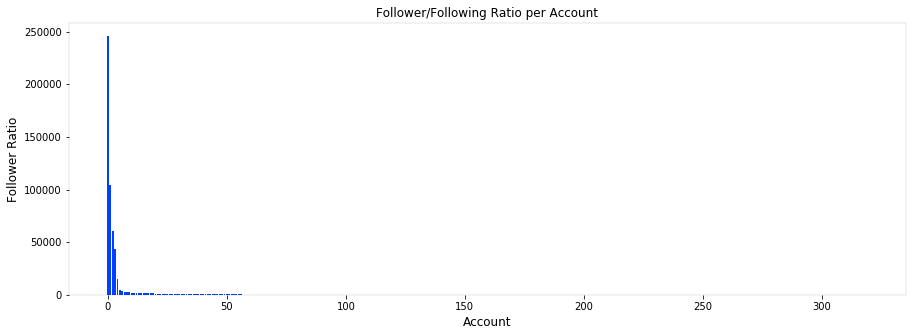

In [138]:
plt.figure(figsize=(15,5))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)
plt.style.use('seaborn-bright')

blue = Color('mediumspringgreen')
colors = list(blue.range_to(Color('blue'),len(foll_ratio['userid'].unique())))
colors = [color.rgb for color in colors]

plt.bar(range(0, len(foll_ratio_df['account'])), foll_ratio_df['ratio'], align='center')
# plt.hlines(np.mean(num_tweets_account), 0, 320, color='red', linewidths=2,
#            linestyles='dashed', label='Mean # of Tweets per User')
# plt.hlines(np.median(num_tweets_account), 0, 320, color='green', linewidths=2,
#            linestyles='dashed', label='Median # of Tweets per User')

plt.title('Follower/Following Ratio per Account')
plt.ylabel('Follower Ratio')
plt.xlabel('Account')
# plt.ylim(0, 5000)
plt.show()

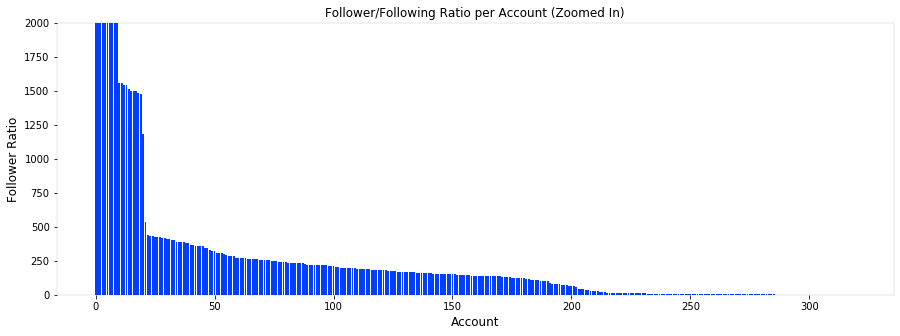

In [139]:
plt.figure(figsize=(15,5))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)
plt.style.use('seaborn-bright')

blue = Color('mediumspringgreen')
colors = list(blue.range_to(Color('blue'),len(foll_ratio['userid'].unique())))
colors = [color.rgb for color in colors]

plt.bar(range(0, len(foll_ratio_df['account'])), foll_ratio_df['ratio'], align='center')
# plt.hlines(np.mean(num_tweets_account), 0, 320, color='red', linewidths=2,
#            linestyles='dashed', label='Mean # of Tweets per User')
# plt.hlines(np.median(num_tweets_account), 0, 320, color='green', linewidths=2,
#            linestyles='dashed', label='Median # of Tweets per User')

plt.title('Follower/Following Ratio per Account (Zoomed In)')
plt.ylabel('Follower Ratio')
plt.xlabel('Account')
plt.ylim(0, 2000)
plt.show()